In [32]:
#!pip install tensorflow
import pandas as pd
import numpy as np
import random as rd
import seaborn as sbs
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import data
from keras.wrappers.scikit_learn import KerasRegressor
import time
from numpy.random import seed
seed(1)

In [33]:
file_data = 'DS_Agua_2017_2022.csv'
path_name='data/'
arquivo = f'{path_name}{file_data}'

In [34]:
dataset = pd.read_csv(arquivo, sep =';', encoding = 'latin1', decimal='.')

In [35]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45240 entries, 1 to 45240
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DT_MEDICAO_HORA         45240 non-null  object 
 1   PRECIPITACAO            45240 non-null  float64
 2   PRESSAO_ATMOSFERICA     45240 non-null  float64
 3   TEMPERATURA_DO_AR_C     45240 non-null  float64
 4   UMIDADE_RELATIVA_DO_AR  45240 non-null  float64
 5   VELOCIDADE_VENTO        45240 non-null  float64
 6   VL_MEDICAO              45240 non-null  float64
dtypes: float64(6), object(1)
memory usage: 2.8+ MB


In [36]:
#verifica se existe variáveis nulas 
dataset.isna().sum()

DT_MEDICAO_HORA           0
PRECIPITACAO              0
PRESSAO_ATMOSFERICA       0
TEMPERATURA_DO_AR_C       0
UMIDADE_RELATIVA_DO_AR    0
VELOCIDADE_VENTO          0
VL_MEDICAO                0
dtype: int64

In [37]:
dataset.head(10)

,DT_MEDICAO_HORA,PRECIPITACAO,PRESSAO_ATMOSFERICA,TEMPERATURA_DO_AR_C,UMIDADE_RELATIVA_DO_AR,VELOCIDADE_VENTO,VL_MEDICAO
1,2017-01-01 00:00:00,0.0,1009.5,25.9,75.0,1.3,5016.845991
2,2017-01-01 01:00:00,0.0,1009.6,25.7,76.0,0.9,4998.296902
3,2017-01-01 02:00:00,0.0,1009.2,25.6,76.0,1.1,5013.330096
4,2017-01-01 03:00:00,0.0,1008.4,25.9,77.0,1.7,4972.739746
5,2017-01-01 04:00:00,0.0,1008.1,23.7,85.0,1.7,4921.942265
6,2017-01-01 05:00:00,0.2,1007.5,23.7,87.0,0.4,4838.136258
7,2017-01-01 06:00:00,0.0,1007.3,24.2,88.0,0.5,4833.215005
8,2017-01-01 07:00:00,0.0,1007.3,24.2,87.0,0.7,4795.247653
9,2017-01-01 08:00:00,0.0,1007.7,24.7,85.0,1.0,4763.098501
10,2017-01-01 09:00:00,0.0,1008.5,25.1,83.0,1.2,4715.598748


In [38]:
#tratando o dataframe
df = pd.DataFrame()
df['VL_MEDICAO']=dataset['VL_MEDICAO']
                                
#transformação da série => janela deslizande com 1 passo de tempo
n_time_steps=2
#transformação da série => janela deslizande com 1 passo de tempo
for n_step in range(1,n_time_steps+1,1):
 df['vl-'+str(n_step)]=dataset['VL_MEDICAO'].shift(n_step)  

#n=1
#df['vl-n']=dataset['VL_MEDICAO'].shift(n)
df['tp-n']=dataset['TEMPERATURA_DO_AR_C']
df['pr-n']=dataset['PRESSAO_ATMOSFERICA']
df['vv-n']=dataset['VELOCIDADE_VENTO']
df['ur-n']=dataset['UMIDADE_RELATIVA_DO_AR']
df['ch-n']=dataset['PRECIPITACAO']

df.dropna(inplace=True)
df.head(15)

,VL_MEDICAO,vl-1,vl-2,tp-n,pr-n,vv-n,ur-n,ch-n
3,5013.330096,4998.296902,5016.845991,25.6,1009.2,1.1,76.0,0.0
4,4972.739746,5013.330096,4998.296902,25.9,1008.4,1.7,77.0,0.0
5,4921.942265,4972.739746,5013.330096,23.7,1008.1,1.7,85.0,0.0
6,4838.136258,4921.942265,4972.739746,23.7,1007.5,0.4,87.0,0.2
7,4833.215005,4838.136258,4921.942265,24.2,1007.3,0.5,88.0,0.0
8,4795.247653,4833.215005,4838.136258,24.2,1007.3,0.7,87.0,0.0
9,4763.098501,4795.247653,4833.215005,24.7,1007.7,1.0,85.0,0.0
10,4715.598748,4763.098501,4795.247653,25.1,1008.5,1.2,83.0,0.0
11,4712.059896,4715.598748,4763.098501,26.2,1009.0,1.5,77.0,0.0
12,4657.193811,4712.059896,4715.598748,28.4,1009.5,1.6,67.0,0.0


In [39]:
#Cria os vetores de X e y para terinamento e teste
vl_medicoes = df.iloc[:,0].values

X = df.iloc[0:dataset.shape[0],1: 6 + n_time_steps]


In [40]:

#Do total de 45239 linhas, foram separadas 75% para treinamento e 25% para teste
nlinhas = 33929 # 75% do dataset
X_train = df.iloc[0:nlinhas,1: 6 + n_time_steps]
X_test = df.iloc[nlinhas:X.shape[0],1:6 + n_time_steps]

y_train = df.iloc[0:nlinhas,0].values
y_test = df.iloc[nlinhas:X.shape[0],0].values


In [41]:

train_feature = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1])) # dados de entrada de treinamento.
train_label = np.array(y_train).reshape((y_train.shape[0], 1, 1)) # dado de saída esperados no treinamento.

N_Nos_Layer1=32 #Número de neurônios do layer 1   # 64
N_Nos_Layer2=64 # Número de neurônios do layer 2  # 128
N_Nos_Layer3=72 # Númer ode neurônios do layer 3

# Armazena a hora de início da execução do Treinamento
Hora_Inicio = time.time()
# Resultados para o batch size encontrados, para 100 epocas, de acordo com a variação do batch size = desta forma o batch size ideal selecionado foi o 4096, considerando que a partir desse ponto o ganho é reduzido drasticamente.
# 128 = 99s   1024 = 20s   2048 = 13s  4096 = 10s 8192 = 9.53s
batch_size = 4096
train_data = data.Dataset.from_tensor_slices((train_feature, train_label))
train_data = train_data.repeat().batch(batch_size, drop_remainder=True)
EPOCAS = 200

model = keras.Sequential()
model.add(layers.LSTM(N_Nos_Layer1, batch_input_shape=(batch_size, train_feature.shape[1], train_feature.shape[2]),  return_sequences=True, activation='relu'))  
model.add(layers.LSTM(N_Nos_Layer2, batch_input_shape=(N_Nos_Layer1, train_feature.shape[1], train_feature.shape[2]), return_sequences=True, activation='relu'))  
#model.add(layers.LSTM(32, batch_input_shape=(N_Nos_Layer2, train_feature.shape[1], train_feature.shape[2]), return_sequences=True, activation='relu'))  
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(32, activation="relu")) #16
model.add(layers.Dense(1))
#model.add(layers.Activation('sigmoid'))

model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mape'])

model.summary()

#history = model.fit(train_feature, train_label, epochs=EPOCAS,shuffle=True,batch_size=batch_size, verbose=2)
steps_per_epoch = len(train_feature) // batch_size 
history = model.fit(train_data, epochs=EPOCAS, steps_per_epoch = steps_per_epoch) 
# Armazena a hora fim da execução do Treinamento
Hora_Fim = time.time()

#Calcula o tempo de duração da execução do treinamento
Duracao = Hora_Fim - Hora_Inicio

print("Duracao =",Duracao)
#model.add(layers.LSTM(N_Nos_Layer1,input_shape=(1,1)))
  #model.add(layers.LSTM(N_Nos_Layer1,input_shape=(5,1), return_sequences=True))
#  model.add(layers.LSTM(N_Nos_Layer2,input_shape=(N_Nos_Layer1,5)))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (4096, 1, 32)             5120      
                                                                 
 lstm_5 (LSTM)               (4096, 1, 64)             24832     
                                                                 
 dense_6 (Dense)             (4096, 1, 32)             2080      
                                                                 
 dense_7 (Dense)             (4096, 1, 32)             1056      
                                                                 
 dense_8 (Dense)             (4096, 1, 1)              33        
                                                                 
Total params: 33,121
Trainable params: 33,121
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
8/8 [==============================] -

In [42]:
val_feature = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))
val_label = np.array(y_test).reshape((y_test.shape[0], 1, 1))


test_data = data.Dataset.from_tensor_slices((val_feature, val_label))
test_data = test_data.repeat().batch(batch_size, drop_remainder=True)

predict = model.predict(test_data, steps=1)
#predict = model.predict(train_data, steps=1)

val_label=val_label[0:len(predict)]

predict = np.array(predict).reshape(4096,1)
val_label = np.array(val_label).reshape(4096,1)

#Calcular o MAPE (Erro médio percentual absoluto)
MAPE = ((np.mean(np.abs(val_label -predict) / (val_label)))) * 100
print("MAPE=", MAPE)


MAPE= 1.7793691302998433


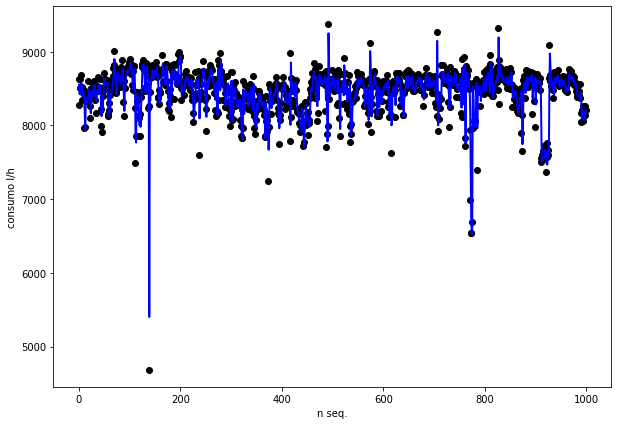

In [43]:

#O gráfico abaixo mostra os valores reais em preto e os valores prditos em azul
npredicts=1000
pyplot.figure(figsize=(10,7)) 
pyplot.scatter(np.arange(0,val_label.shape[0],1)[0:npredicts],np.array(val_label)[0:npredicts], color = 'black')
pyplot.plot(np.arange(0,val_label.shape[0],1)[0:npredicts], np.array(predict)[0:npredicts], color = 'blue', linewidth=2)
pyplot.xlabel('n seq.')
pyplot.ylabel('consumo l/h')
pyplot.show()